# Cours M2 Principes de modélisation: simulations numériques de l'équation de transport

In [1]:
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
import scipy.optimize
import math 
from math import sin, pi
import os
%matplotlib notebook
from matplotlib.animation import FuncAnimation

Le but est de résoudre par une méthode de différences finies l'équation de transport
$$
\partial_t v(t,x) + \partial_x v(t,x) = 0 \qquad \text{sur $(0,1)$}
$$
avec des conditions de bord périodiques ($v(t,0) = v(t,1)$) et une condition initiale $v(0,x) = v_i(x)$. 


Soit $X \in \mathbb{N}^*$. On note $\displaystyle \Delta x := \frac{1}{X}$ et pour tout $i \in \mathbb{Z}$, on notera $x_i = i \Delta x$ de telle sorte que $x_0 = 0 < x_1 < \cdots < x_X = 1$. 

In [2]:
X = 100 # Nombre de points de discretisation
xx = np.linspace(0, 1, X+1)
dx = 1.0/X
print("les deux valeurs extremales de xx sont ",xx[0]," et ",xx[X])

les deux valeurs extremales de xx sont  0.0  et  1.0


In [3]:
#On definit le pas de temps et le nombre de pas de temps
#dt = 0.015 # 0.05 0.09 0.11 pour X=10
dt = 0.005 # BIEN 0.005 0.009 0.011 pour X=100
#M = 40 # pour X=10
M = 400 # pour X=100
instant = np.zeros(M)
for ii in range(0,M):
    instant[ii] = ii*dt

# On definit la condition initiale (periodique!)
V0full = np.zeros(X+1) 
regul = True # True pour CI reguliere, False sinon
regul = False
if regul:
    # CI reguliere
    for i in range(0,X+1):
        V0full[i] = sin(2*pi*xx[i])
else:
    # CI irreguliere (pour cette CI, décentré amont, LF et LW ne sont pas parfaits)
    pic = int(2*X/5)
    picc = int(3*X/5)
    for i in range(pic,picc):
        V0full[i] = 1.
print("les deux valeurs extremales de V0full sont ",V0full[0]," et ",V0full[X])

# On prend la restriction en eliminant le dernier ddl (car CL periodiques)
V0 = np.zeros(X) 
for i in range(0,X):
    V0[i] = V0full[i]
print("les deux valeurs extremales de V0 sont ",V0[0]," et ",V0[X-1])

# On evalue la valeur de la condtion CFL $\Delta t / \Delta x$ 
# quantité pertinente pour le schéma decentré amont, LF, LW: elle doit etre inferieure à 1
CFL = dt/dx
print("CFL = ", CFL)

les deux valeurs extremales de V0full sont  0.0  et  0.0
les deux valeurs extremales de V0 sont  0.0  et  0.0
CFL =  0.5


<IPython.core.display.Javascript object>


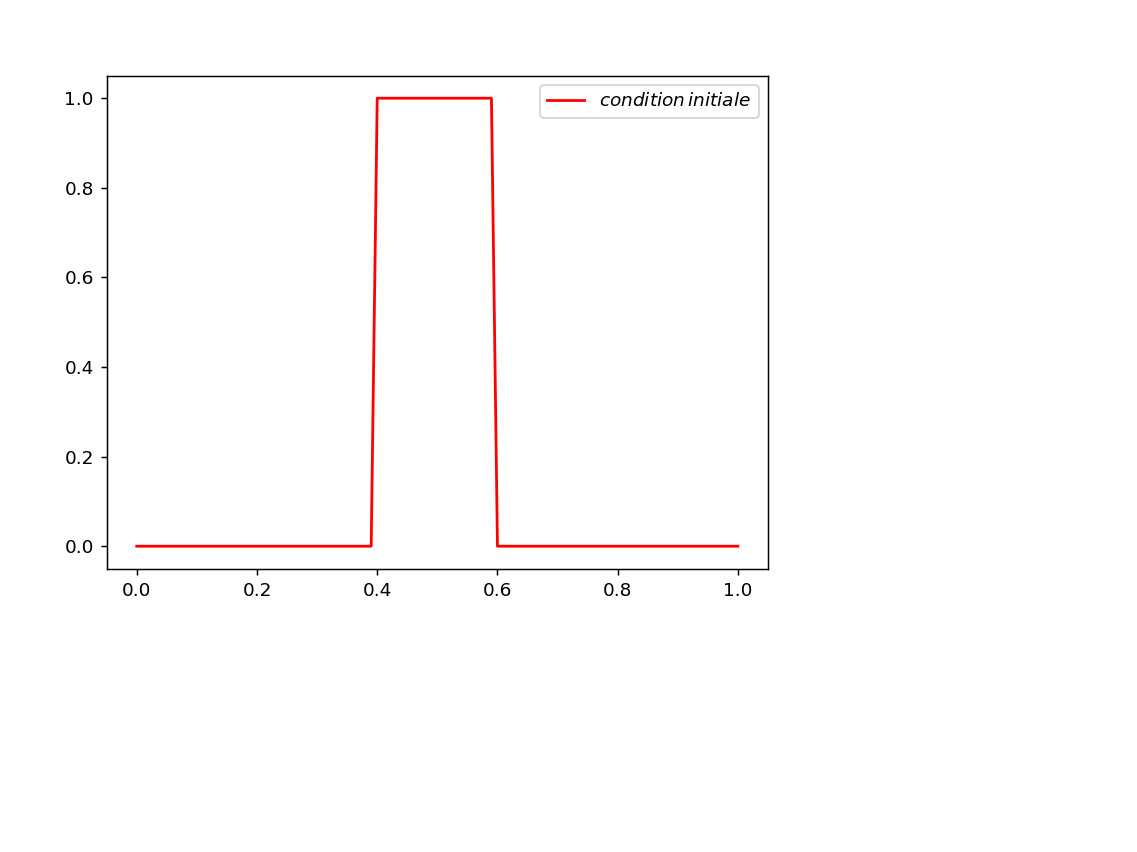

In [4]:
# On visualise la condition initiale
plt.plot(xx,V0full, 'r', label ="$condition \, initiale$")
plt.legend()
plt.show()

In [5]:
plt.close()

In [6]:
# Definition de matrices utiles

# matrice identite
Idd = np.eye(X) 

# matrice sur-diagonale
MatU = np.zeros((X,X))
for i in range(0,X-1):
   MatU[i,i+1] = 1
MatU[X-1,0] = 1 

# matrice sous-diagonale
MatD = np.zeros((X,X))
for i in range(1,X):
   MatD[i,i-1] = 1
MatD[0,X-1] = 1 

# 1- Schéma explicite centré

In [7]:
# Definition de la matrice de passage

D = np.zeros((X,X))
D = Idd - (dt/(2*dx))*(MatU-MatD)

In [8]:
# visualisation de la matrice de passage
print(D)

[[ 1.   -0.25  0.   ...  0.    0.    0.25]
 [ 0.25  1.   -0.25 ...  0.    0.    0.  ]
 [ 0.    0.25  1.   ...  0.    0.    0.  ]
 ...
 [ 0.    0.    0.   ...  1.   -0.25  0.  ]
 [ 0.    0.    0.   ...  0.25  1.   -0.25]
 [-0.25  0.    0.   ...  0.    0.25  1.  ]]


In [9]:
# On realise l'iteration en temps 
     
# On va stocker dans Vtab la solution aux differents pas de temps
Vtab = np.zeros((X,M))
V = V0

for ii in range(0,M):
    Vtab[:,ii] = V
    Vnew = np.dot(D,V) #produit matriciel
    V = Vnew
    
# On complete les tableaux pour avoir le dernier point
Vfull = np.zeros((X+1,M))
for ii in range(0,M):
    for jj in range(0,X):
        Vfull[jj,ii] = Vtab[jj,ii]
    Vfull[X,ii] = Vtab[0,ii]

Le but des lignes de code ci-dessous est d'afficher l'évolution de la fonction $v(t,x)$

<IPython.core.display.Javascript object>


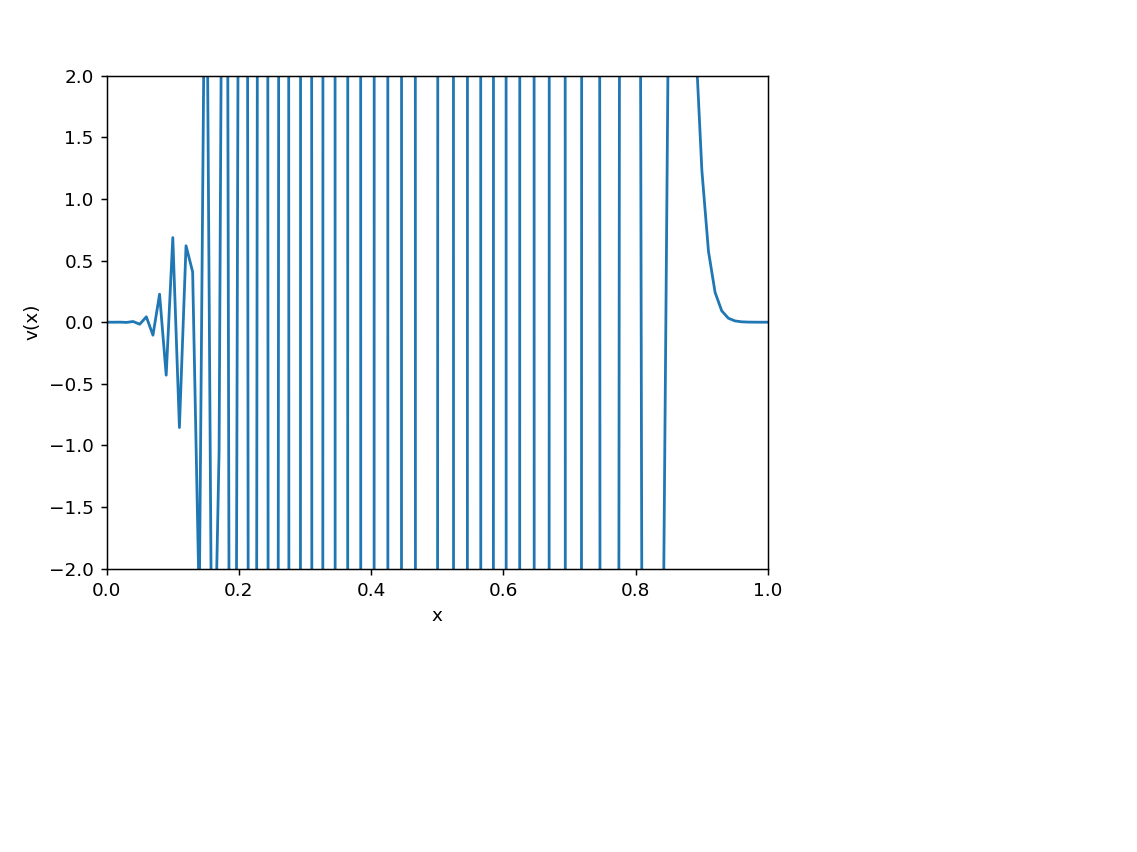

In [10]:
## Le but de cette fonction est d'afficher l'évolution de v(t,x) au cours du temps
fig1, ax1 = plt.subplots(1)
plotV,  = ax1.plot(xx,Vfull[:,0])

def animate(p):
    VV = Vfull[:,p]
    plotV.set_ydata(VV) 
    
def init(): 
    ax1.set_xlim(0, 1)
    ax1.set_ylim( -2., 2.)
    ax1.set_xlabel('x')
    ax1.set_ylabel('v(x)')    
    return plotV,

step = 1
steps = np.arange(1,M,step)
ani1 = FuncAnimation(fig1, animate,steps, init_func = init, interval = 100, blit = True)

In [11]:
plt.close()

In [12]:
# valeur maximale au cours du temps
Vmax = np.zeros(M)
for ii in range(0,M):
    Vmax[ii] = max(Vfull[:,ii])

<IPython.core.display.Javascript object>


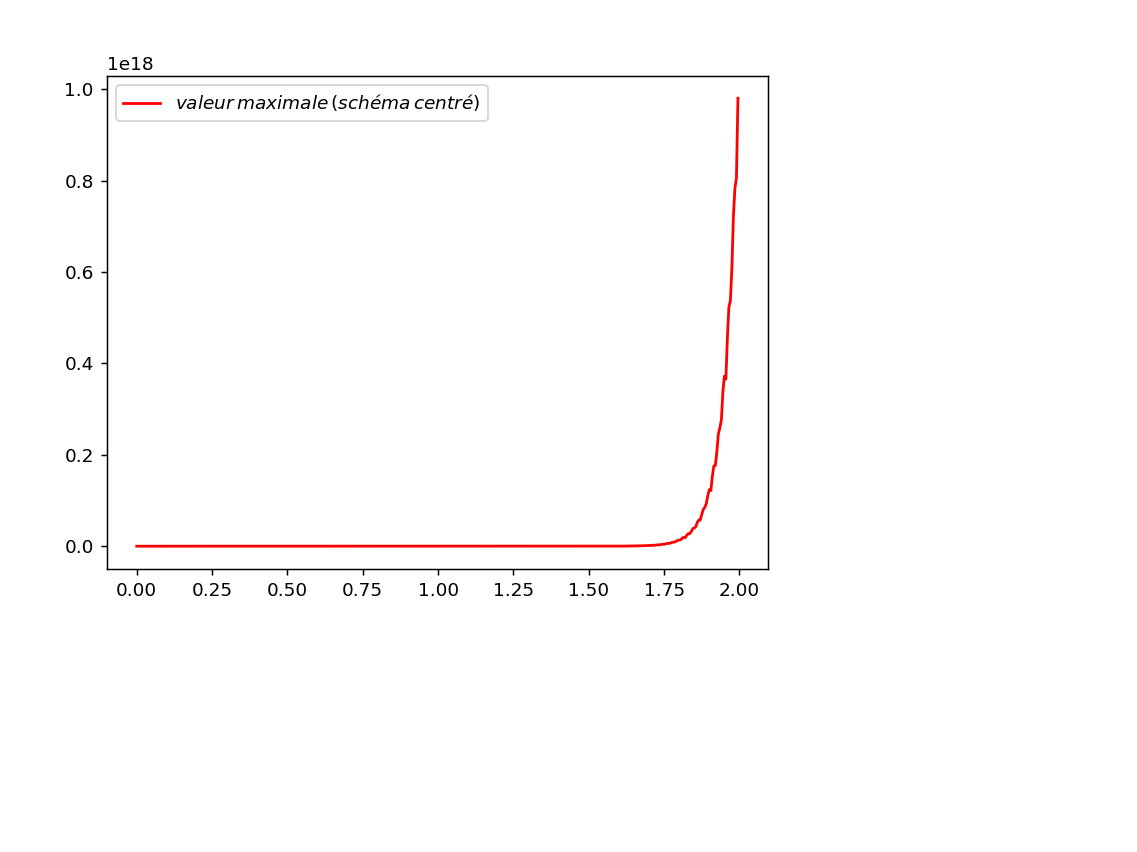

In [13]:
# On visualise la valeur max au cours du temps
plt.plot(instant,Vmax, 'r', label ="$valeur \, maximale \, (schéma \, centré)$")
plt.legend()
plt.show()

In [14]:
plt.close()

# 2- Schéma décentré aval

In [15]:
# Definition de la matrice de passage

D = np.zeros((X,X))
D = Idd - (dt/dx)*(MatU-Idd)

In [16]:
# visualisation de la matrice de passage
print(D)

[[ 1.5 -0.5  0.  ...  0.   0.   0. ]
 [ 0.   1.5 -0.5 ...  0.   0.   0. ]
 [ 0.   0.   1.5 ...  0.   0.   0. ]
 ...
 [ 0.   0.   0.  ...  1.5 -0.5  0. ]
 [ 0.   0.   0.  ...  0.   1.5 -0.5]
 [-0.5  0.   0.  ...  0.   0.   1.5]]


In [17]:
# On realise l'iteration en temps 
     
# On va stocker dans Vtab la solution aux differents pas de temps
Vtab = np.zeros((X,M))
V = V0

for ii in range(0,M):
    Vtab[:,ii] = V
    Vnew = np.dot(D,V) #produit matriciel
    V = Vnew
    
# On complete les tableaux pour avoir le dernier point
Vfull = np.zeros((X+1,M))
for ii in range(0,M):
    for jj in range(0,X):
        Vfull[jj,ii] = Vtab[jj,ii]
    Vfull[X,ii] = Vtab[0,ii]

Le but des lignes de code ci-dessous est d'afficher l'évolution de la fonction $v(t,x)$

<IPython.core.display.Javascript object>


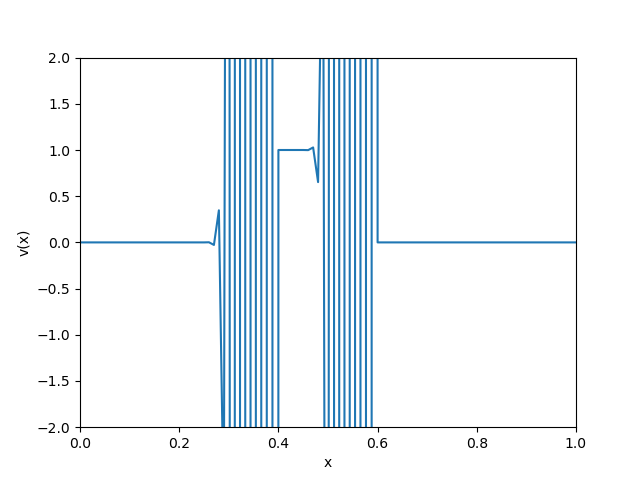

In [18]:
## Le but de cette fonction est d'afficher l'évolution de v(t,x) au cours du temps
fig1, ax1 = plt.subplots(1)
plotV,  = ax1.plot(xx,Vfull[:,0])

def animate(p):
    VV = Vfull[:,p]
    plotV.set_ydata(VV) 
    
def init(): 
    ax1.set_xlim(0, 1)
    ax1.set_ylim( -2., 2.)
    ax1.set_xlabel('x')
    ax1.set_ylabel('v(x)')    
    return plotV,

step = 1
steps = np.arange(1,M,step)
ani1 = FuncAnimation(fig1, animate,steps, init_func = init, interval = 100, blit = True)

In [19]:
plt.close()

In [20]:
# valeur maximale au cours du temps
Vmax = np.zeros(M)
for ii in range(0,M):
    Vmax[ii] = max(Vfull[:,ii])

<IPython.core.display.Javascript object>


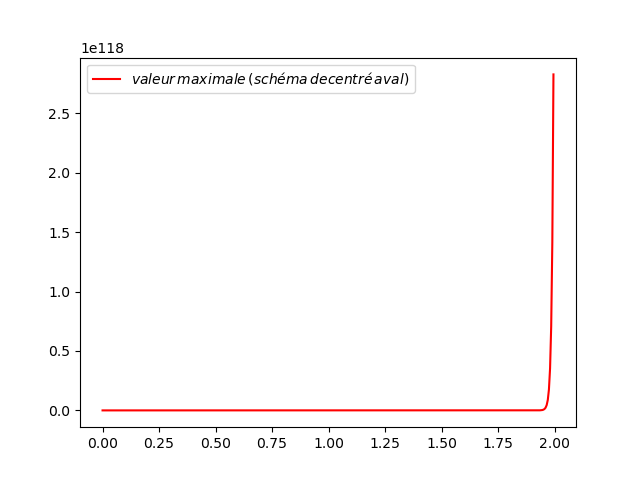

In [21]:
# On visualise la valeur max au cours du temps
plt.plot(instant,Vmax, 'r', label ="$valeur \, maximale \, (schéma \, decentré \, aval)$")
plt.legend()
plt.show()

In [22]:
plt.close()

# 3- Schéma décentré amont

In [23]:
# Definition de la matrice de passage

D = np.zeros((X,X))
D = Idd - (dt/dx)*(Idd-MatD)

# On rappelle la valeur de la condtion CFL $\Delta t / \Delta x$, qui doit etre inferieure à 1
print("CFL = ", CFL)

CFL =  0.5


In [24]:
# visualisation de la matrice de passage
print(D)

[[0.5 0.  0.  ... 0.  0.  0.5]
 [0.5 0.5 0.  ... 0.  0.  0. ]
 [0.  0.5 0.5 ... 0.  0.  0. ]
 ...
 [0.  0.  0.  ... 0.5 0.  0. ]
 [0.  0.  0.  ... 0.5 0.5 0. ]
 [0.  0.  0.  ... 0.  0.5 0.5]]


In [25]:
# On realise l'iteration en temps 
     
# On va stocker dans Vtab la solution aux differents pas de temps
Vtab = np.zeros((X,M))
V = V0

for ii in range(0,M):
    Vtab[:,ii] = V
    Vnew = np.dot(D,V) #produit matriciel
    V = Vnew
    
# On complete les tableaux pour avoir le dernier point
Vfull = np.zeros((X+1,M))
for ii in range(0,M):
    for jj in range(0,X):
        Vfull[jj,ii] = Vtab[jj,ii]
    Vfull[X,ii] = Vtab[0,ii]

Le but des lignes de code ci-dessous est d'afficher l'évolution de la fonction $v(t,x)$

<IPython.core.display.Javascript object>


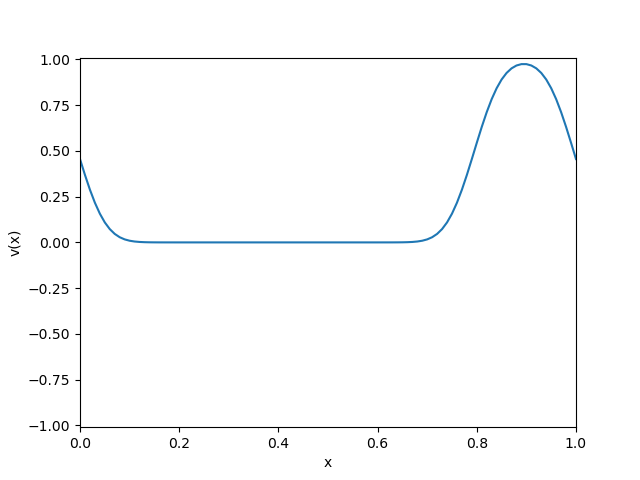

In [26]:
## Le but de cette fonction est d'afficher l'évolution de v(t,x) au cours du temps
fig1, ax1 = plt.subplots(1)
plotV,  = ax1.plot(xx,Vfull[:,0])

def animate(p):
    VV = Vfull[:,p]
    plotV.set_ydata(VV) 
    
def init(): 
    ax1.set_xlim(0, 1)
    ax1.set_ylim( -1.01, 1.01)
    ax1.set_xlabel('x')
    ax1.set_ylabel('v(x)')    
    return plotV,

step = 1
steps = np.arange(1,M,step)
ani1 = FuncAnimation(fig1, animate,steps, init_func = init, interval = 100, blit = True)

In [27]:
plt.close()

In [28]:
# valeur maximale au cours du temps
Vmax = np.zeros(M)
for ii in range(0,M):
    Vmax[ii] = max(Vfull[:,ii])

<IPython.core.display.Javascript object>


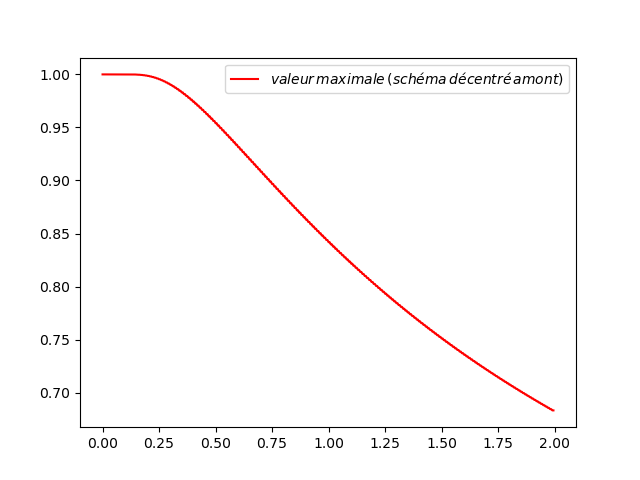

In [29]:
# On visualise la valeur max au cours du temps
plt.plot(instant,Vmax, 'r', label ="$valeur \, maximale \, (schéma \, décentré \, amont)$")
plt.legend()
plt.show()

In [30]:
plt.close()